# Simulate a user accessing scenes to estimate # of sectors needed to unseal

## Imports

In [1]:
%matplotlib inline
import random
import geopandas as gpd
from scipy.spatial import KDTree
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# pd.options.display.max_rows = 999
import folium

## Prepare Geometries

[Landsat Descending Path/Row shapefile](https://www.usgs.gov/media/files/landsat-wrs-2-descending-path-row-shapefile)

[US States boundaries 20m:1 shapefile](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html)

[MSA boundaries 20m:1 shapefile](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html)

In [2]:
def process_geometry(geom, study_area):
    """
    Reproject geometry to study area projection and clip to study area. Reset index because features are dropped during clipping.
    """
    geom.to_crs(study_area.crs, inplace=True)
    geom = gpd.clip(geom, study_area)
    geom.reset_index(inplace=True, drop=True)
    return geom

us_states_shp = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_20m.zip")[["geometry", "STUSPS"]]
study_area = us_states_shp[us_states_shp["STUSPS"].isin(["AK", "HI", "PR", "VI", "GU", "AS", "MP", "UM"]) == False] # Remove non-continental US states

landsat_scenes_shp = gpd.read_file("https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/WRS2_descending_0.zip")[["PATH", "ROW", "geometry"]]
landsat_scenes_shp = process_geometry(landsat_scenes_shp, study_area)

us_counties_shp = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_20m.zip")[["geometry", "STATEFP", "COUNTYFP"]]
us_counties_shp = process_geometry(us_counties_shp, study_area)

us_regions_shp = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_region_20m.zip")[["geometry", "NAME"]]
us_regions_shp = process_geometry(us_regions_shp, study_area)

msa_boundaries_shp = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_csa_20m.zip")[["CSAFP", "geometry"]]
msa_boundaries_shp = process_geometry(msa_boundaries_shp, study_area)

# hexbins_250km = gpd.read_file("https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/250km_hexbins.zip")[["geometry"]]

/Users/jsolly.admin/Documents/code/easier/venv/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/Users/jsolly.admin/Documents/code/easier/venv/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/Users/jsolly.admin/Documents/code/easier/venv/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting

In [3]:
# Number of scenes in the Continental US
print(f"Number of scenes in the Continental US: {len(landsat_scenes_shp)}")

Number of scenes in the Continental US: 457


## Save clipped landsat scenes to CSV without geometry

In [4]:
# saved landsat scenes clipped to study area without geometry
landsat_scenes_shp[["PATH", "ROW"]].to_csv("../../data/GIS/landsat_scenes_clipped.csv", index=False)

## Pack Sectors (nearest neighbors, sequential)

In [4]:
sector_scene_count = 25
landsat_scenes_with_sectors = landsat_scenes_shp.copy()
scenes = landsat_scenes_with_sectors[["PATH", "ROW"]].sort_values(by=["PATH", "ROW"]).values

def array_present_in_array(array, array_to_check):
    """Check if an array is present in another array"""
    if (array == array_to_check).all(1).any():
        return True

car_scenes = {}

curr_indx = 0
 # While there are still scenes to be assigned to sectors
while len(scenes) > 0:
    current_sector = f"Sector {curr_indx}"
    if len(scenes) < sector_scene_count:
        car_scenes[current_sector] = scenes
        break

    tree = KDTree(scenes)
    scene_to_query = scenes[0]
    nearest_scene_indices = tree.query(scene_to_query, k=25)[1]
    nearest_scenes = scenes[nearest_scene_indices]

    car_scenes[current_sector] = nearest_scenes
    # Remove the scenes that were assigned to the sector
    scenes = np.delete(scenes, nearest_scene_indices, axis=0)
    curr_indx += 1

## Pack the sectors (Naive)

In [5]:
# sector_scene_count = 25
# landsat_scenes_clipped_with_sectors = landsat_scenes_clipped.copy()
# scenes = landsat_scenes_clipped_with_sectors[["PATH", "ROW"]].values

# car_scenes = {}
# curr_indx = 0
# while len(scenes) > 0:
#     current_sector = f"Sector {curr_indx}"
#     if len(scenes) < sector_scene_count:
#         car_scenes[current_sector] = scenes
#         break

#     car_scenes[current_sector] = scenes[:sector_scene_count]
#     scenes = scenes[sector_scene_count:] # Remove the scenes that were assigned to the sector
#     curr_indx += 1

## This is NOT efficient, but it works (Assign scenes to sectors and then drop path/row)

In [6]:
def array_present_in_array(array, array_to_check):
    """Check if an array is present in another array"""
    if (array == array_to_check).all(1).any():
        return True

add_sector_to_scene = landsat_scenes_with_sectors.copy()
for sector in car_scenes.items():
    for row in add_sector_to_scene.itertuples():
        if sector[0] == "Sector 17" and row.PATH == 32 and row.ROW == 32:
            pass
        if array_present_in_array(np.array([row.PATH, row.ROW]), sector[1]):
            add_sector_to_scene.at[row.Index, "Sector"] = sector[0]

add_sector_to_scene.drop(columns=["PATH", "ROW"], inplace=True)

## Intersect geometries with Landsat Scenes tagged with Sector ID

In [7]:
geometries_clipped_intersected = []
for geometry in geometries_clipped[:-1]: # Leave out the landsat scenes
    geometry = gpd.sjoin(geometry, add_sector_to_scene, how="inner", predicate="intersects").drop(columns=["geometry", "index_right"])
    geometries_clipped_intersected.append(geometry)

## Combine all geometries into one dataframe

In [8]:
states = geometries_clipped_intersected[0]
counties = geometries_clipped_intersected[1]
regions = geometries_clipped_intersected[2]
msa = geometries_clipped_intersected[3]

## Save all the geometries to a CSV

In [18]:
# Save the geometries to CSV Files
states.to_csv("../../data/GIS/states.csv", index=False)

## Summary Statistics (State)

In [13]:
# Group each state by STUSPS and count number of scenes in each state. Show a Sum of the total number of scenes.
states_grouped = states.groupby("STUSPS").agg({"Sector": "count"}).reset_index()
states_grouped.rename(columns={"Sector": "Scene Count"}, inplace=True)
states_grouped.sort_values(by="Scene Count", ascending=False, inplace=True)
# Show Scene whole number Count total 
states_grouped.loc["Total"] = states_grouped[["Scene Count"]].sum()
states_grouped



,STUSPS,Scene Count
41,TX,49.0
3,CA,38.0
24,MT,35.0
31,NV,28.0
21,MN,28.0
30,NM,27.0
11,ID,26.0
2,AZ,26.0
35,OR,26.0
20,MI,26.0


In [19]:
# Group by STUSPS and add count of unqiue sectors in a new column called "Sectors Hit"
states_grouped = states.groupby("STUSPS").agg({"Sector": "nunique"}).reset_index().sort_values(by="Sector", ascending=False)
states_grouped.rename(coluåmns={"Sector": "Sectors Hit"}, inplace=True) 
states_grouped.head(50)



,STUSPS,Sectors Hit
4,CO,5
31,NV,5
34,OK,5
48,WY,4
35,OR,4
2,AZ,4
3,CA,4
30,NM,4
41,TX,4
39,SD,4


In [16]:
# Show standard deviation of sectors hit
states_grouped["Sectors Hit"].std()

1.1547005383792515

## Plot Results

Text(0.5, 1.0, 'Landsat Scenes and Sectors')

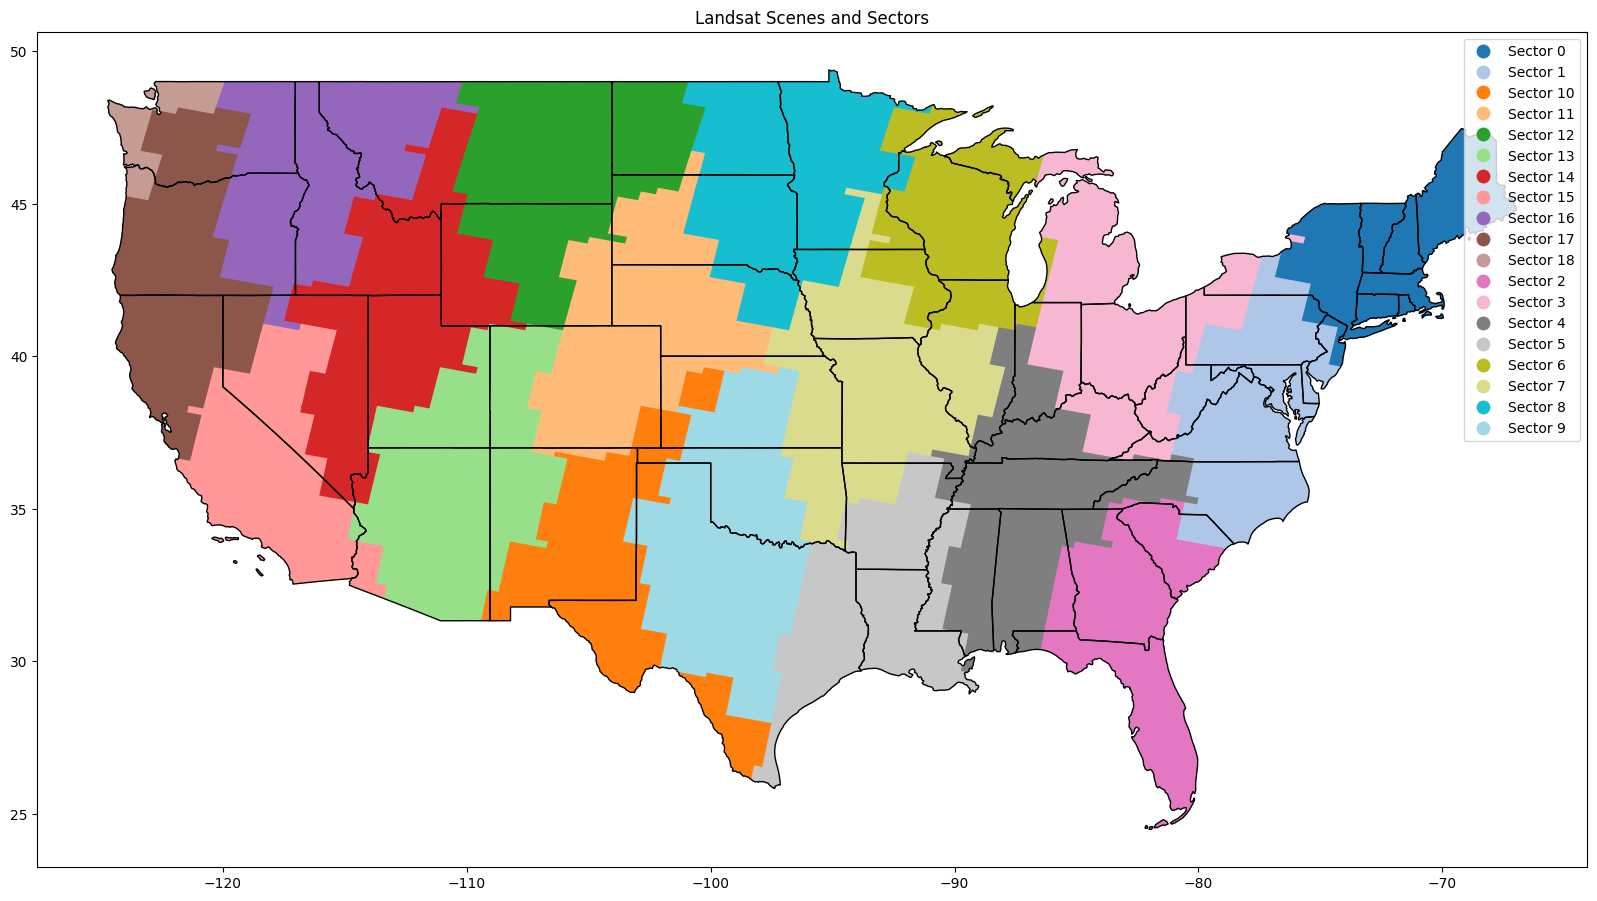

In [192]:
# Plot the States with sectors shown with some transparency
# ax = add_sector_to_scene.plot(column="Sector", figsize=(20, 20), alpha=0.5, legend=True)
# Plot the States with some transparency and dark borders.

ax = add_sector_to_scene.plot(column="Sector", legend=True, cmap="tab20", figsize=(20, 20))
us_states_continential.plot(ax=ax, color="none", edgecolor="black", linewidth=1)
plt.title("Landsat Scenes and Sectors")

# Plot unqiue sectors with tab20 colors



